> ### EEE4423: Signal Processing Lab

# LAB \#14: CycleGAN

<h4><div style="text-align: right"> Due date:  2020.06.23</div> <br>
<div style="text-align: right"> Please upload your file @ yscec by 2 PM in the form of [ID_Name_Lab14.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">2014142243 차현수</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2021-06-05 22:10:54.773835


## 1. Implementation for CycleGAN
>
>
> <img src="https://drive.google.com/uc?id=1v8LUzqE7qjQnN_HtuO4bP9hogq2FVyyp" alt="no_image" style="width: 800px;"/><br>
>
> * Cycle GAN leverages a cycle consistency in image-to-image translation
> * Unlike a conditional GAN, the cycle GAN considers <U>unpaired training data</U>
>
> **1. Dataset**
>
>   * MNIST dataset
>   * SVHN dataset
>   * Note that the MNIST data is gray, where the number of the channel is 1
>
> **2. Network architecture**
>
>   * **Overall architecture**
>
> <img src="https://drive.google.com/uc?id=1YExtjmpAu57bPkgh6OqEHyMDNj7Wy7Gk" alt="no_image" style="width: 600px;"/><br>
>
>   * **Generative model G**
>     * Xavier initialization (Glorot & Bengio [3])
>       * It makes sure the weights to keep the propagation in a reasonable range through many layers
>       * $V(W)= {2 \over n_{in}+n_{out}}$
>       * Use <code>nn.init.xavier_uniform_</code> for the Xavier initialization
>
>     * The generative model has three components:
>       1. Encoder: 
>         * Convolutional network for feature extracting
>         * 2 convolutional layers and 2 LeakyReLU activations
>         * The output channel sizes are 64, 128 respectively<br>
>         * The kernel size of the convolutional layers are 7 and 3, respectively<br>
>            (You can use different sizes whatever you want, but we recommend those sizes)
>         * All the strides are 2
>         * Use batch normalization except for the first layer
>
>       2. Transformer: 
>         * Learn how it would like to transform the feature vector of and image from A to B. <br> 
>         * Use the resnet blok which contains the skip-connetction between the input and output for transformation<br>
>            (Please refer to <U>He et al.</U>[3])
>         * 3 resnet block layers and each of layer is followed by LeakyReLU activation
>         * All the output channel sizes are 128
>         * All the kernel sizes and strides are 3 and 1, respectively
>      
>       3. Decoder: 
>         * Upconvolutional network for reconstructing an image
>         * 2 upconvolutional layers, one LeakyReLU activations, and one Tanh activation which is for the last layer
>         * The output channel sizes are 128, 64, and 3, respectively for the SVHN data, and 128, 64, and 1, respectively for the MNIST data <br>
>         * All the kernel sizes and strides are 4 and 2, respectively
>         * Use batch normalization except for the last layers
>
>
>
> <img src="https://drive.google.com/uc?id=15pzDH7bCworNtjaJpLPz0aH4_FMtl1Jd" alt="no_image" style="width: 800px;"/><br>
>
>
>   * **Discriminative model D**
>     * Xavier Initialization
>     * It contains 4 convolutional layers, 3 LeakyReLU activations, and one Sigmoid activation which is for the last layer
>     * The output channel sizes are 64, 128, 256, and 1, respectively
>     * All the kernel sizes are 4 except for the last kernel size which is 1
>     * The strides from the first two layers are 2 and the rest of them are 1
>     * Use batch normalization([4]) except for the first and last layers
>
>
>
> <img src="https://drive.google.com/uc?id=1XteTcNDxYiN8CP6XKoZ37jdu1yJNMNXl" alt="no_image" style="width: 600px;"/><br>
>
>
> **3. Loss function**<br>
> (In the paper, the authors use the L2 loss for the GAN loss, but the binary cross entropy loss also works well)
>  * **Discriminative model $D_X$ and $D_Y$**
>    * The loss for $D_Y$ is followed as<br>
>      * Binary cross entropy loss for the real data
>      * Binary cross entropy loss for the fake data <br>
>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_Y(y_i))+(1-l_i^{real})log(1-D_Y(y_i)) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{fake}log(D_Y(G_Y(x_i)))+(1-l_i^{fake})log(1-D_Y(G_Y(x_i)))$ <br>
>
>  *
>    * The loss for $D_X$ is followed as<br>
>      * Binary cross entropy loss for the real data
>      * Binary cross entropy loss for the fake data <br>
>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_X(x_i))+(1-l_i^{real})log(1-D_X(x_i)) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{fake}log(D_X(G_X(y_i)))+(1-l_i^{fake})log(1-D_X(G_X(y_i)))$ <br>
>
>    ($l_i^{real}=1, l_i^{fake}=0$) <br>
>    ($G_Y$ is the generator where $x_i$ translate to $y_i$ and vice versa)
>
>
>  * **Generative model $G_X$ and $G_Y$**<br>
>
>      * Binary cross entropy loss for the real data (It is actually fake)
>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_X(G_X(y_i)))+(1-l_i^{real})log(1-D_X(G_X(y_i))) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_Y(G_Y(x_i)))+(1-l_i^{real})log(1-D_Y(G_Y(x_i))) $ <br>
>
>    ($l_i^{real}=1$)
>    
>      * The cycle loss for measuring difference between $x_i$ and $G_Y(G_X(x_i))$ and vice versa
>
>    $-{1 \over N} \sum^{N}_{i=1} \lvert\lvert G_Y(G_X(y_i))-y_i \rvert\rvert_1$ <br>
>    $-{1 \over N} \sum^{N}_{i=1} \lvert\lvert G_X(G_Y(x_i))-x_i \rvert\rvert_1$

## 2. Cycle GAN with Pytorch

In [2]:
import os
import os.path as osp
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Parameter Setting
* You can adjust the parameters to yourself

In [3]:
print('STEP 0: PARAMETER SETTING')

# Data root directory
train_X_root = 'dataset/lab14/mnist/'
train_Y_root = 'dataset/lab14/svhn/'

# Weight save directory
vis_num = 2
save_dir = 'cyclegan'
if not osp.exists(save_dir):
    os.makedirs(save_dir)

# Batch size during training
bs = 64

# Size of image
img_height = 32
img_width = 32
img_size = 32
img_channel = 3

# Channels of generator feature
gfc = 64

# Channels of discriminator feature
dfc = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizing
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Real or Fake label
real_label = 1
fake_label = 0

STEP 0: PARAMETER SETTING


In [4]:
print('STEP 1: LOADING DATASET')

transform_1ch = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

transform_3ch = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_X_set = dset.MNIST(root=train_X_root,
                         train=True,
                         transform=transform_1ch,
                         download=False)
train_Y_set = dset.SVHN(root=train_Y_root,
                        split='train',
                        transform=transform_3ch,
                        download=False)
test_X_set = dset.MNIST(root=train_X_root,
                         train=False,
                         transform=transform_1ch,
                         download=False)
test_Y_set = dset.SVHN(root=train_Y_root,
                        split='test',
                        transform=transform_3ch,
                        download=False)

STEP 1: LOADING DATASET


In [5]:
print('STEP 2: MAKING DATASET ITERABLE')

train_X_loader = torch.utils.data.DataLoader(train_X_set,
                                             batch_size=bs, 
                                             shuffle=True,
                                             drop_last=True)

train_Y_loader = torch.utils.data.DataLoader(train_Y_set,
                                             batch_size=bs, 
                                             shuffle=True,
                                             drop_last=True)

test_X_loader = torch.utils.data.DataLoader(test_X_set,
                                             batch_size=bs, 
                                             shuffle=False,
                                             drop_last=True)

test_Y_loader = torch.utils.data.DataLoader(test_Y_set,
                                             batch_size=bs, 
                                             shuffle=False,
                                             drop_last=True)

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

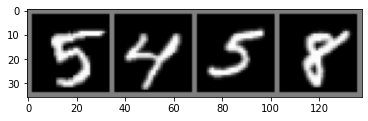

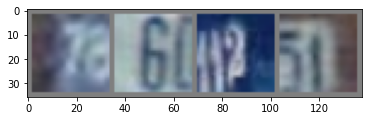

In [7]:
data_loader_X_sample = torch.utils.data.DataLoader(train_X_set,
                                                 batch_size=4, 
                                                 shuffle=True)
data_loader_Y_sample = torch.utils.data.DataLoader(train_Y_set,
                                                 batch_size=4, 
                                                 shuffle=True)

# Get a batch of training data
X = next(iter(data_loader_X_sample))
Y = next(iter(data_loader_Y_sample))

# Make a grid from batch
out_X = torchvision.utils.make_grid(X[0])
out_Y = torchvision.utils.make_grid(Y[0])

imshow(out_X)
imshow(out_Y)

### Utils 
* Use the below code for the convolution or the upconvolution

### *References*
[1] Zhu et al., "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks", *ICCV*, 2017. <br>
[2] https://hardikbansal.github.io/CycleGANBlog/ <br>
[3] Glorot & Bengio, "Understanding the difficulty of training deep feedforward neural networks", *AISTATS* 2010. <br>
[4] Ioffe & Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", *ICML* 2015.

In [8]:
def conv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation.lower() == 'relu':
        layers += [nn.ReLU(inplace=True)]
    if activation.lower() == 'leakyrelu':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation.lower() == 'tanh':
        layers += [nn.Tanh()]
    if activation.lower() == 'sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)
        
def upconv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation.lower() == 'relu':
        layers += [nn.ReLU(inplace=True)]
    if activation.lower() == 'leakyrelu':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation.lower() == 'tanh':
        layers += [nn.Tanh()]
    if activation.lower() == 'sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)

def transpose(ndarray):
    return np.transpose(ndarray, [0,2,3,1])

def gray2rgb(ndarray):
    return np.concatenate((ndarray, ndarray, ndarray), axis=2)

### 2.1 Write the code (Generator) [3 points]
* You need to set the hyperparameters for implementing the upconvolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [9]:
print('STEP 3-1: CREATE MODEL CLASS (Generator)')


# [input channels, output channels, kernel_size, strides, paddings]
### Encoder
# 2 conv, 2 leaky, output: 64, 128
# kernel size: 7, 3 -> 4, 3
# all stride 2
# no fist layer batch norm

# When I set the kernel size to 7, the model did not work properly because the size did not fit. 
# It worked properly when set to 4.
cfg_g_enc_X = [[3,   gfc,     4, 2, 1, 'leakyrelu'],
               [gfc, gfc * 2, 3, 2, 1, 'leakyrelu']]
cfg_g_enc_Y = [[1,   gfc,     4, 2, 1, 'leakyrelu'],
               [gfc, gfc * 2, 3, 2, 1, 'leakyrelu']]

### Transformer
# All output size 128, kerenl size = 3, stride = 1
cfg_g_trans = [[gfc * 2, gfc * 2, 3, 1, 1, 'leakyrelu'], 
               [gfc * 2, gfc * 2, 3, 1, 1, 'leakyrelu'], 
               [gfc * 2, gfc * 2, 3, 1, 1, 'leakyrelu']]

### Decoder
# 2 upconv, 1 leaky, 1 tanh(last)
# output size 128, 64, 3(svhn), 128,64,1 (mnist)
# all kernel size 4, all stride 2
# no batch norm last layer
cfg_g_dec_X = [[gfc * 2, gfc, 4, 2, 1, 'leakyrelu'], 
               [gfc,       1, 4, 2, 1, 'tanh']]
cfg_g_dec_Y = [[gfc * 2, gfc, 4, 2, 1, 'leakyrelu'], 
               [gfc,       3, 4, 2, 1, 'tanh']]


class Generator_X(nn.Module): # SVHN to MNIST
    def __init__(self):
        super(Generator_X, self).__init__()
        
        #############
        # CODE HERE #
        # Encoder
        self.conv1 = conv2d(cfg_g_enc_X[0], batch_norm=False)
        self.conv2 = conv2d(cfg_g_enc_X[1])
        
        # Transformation
        self.block1 = conv2d(cfg_g_trans[0])
        self.block2 = conv2d(cfg_g_trans[1])
        self.block3 = conv2d(cfg_g_trans[2])
        
        # Decoder
        self.conv3 = upconv2d(cfg_g_dec_X[0])
        self.conv4 = upconv2d(cfg_g_dec_X[1], batch_norm=False)
        
        #############
        
    def forward(self, x):
        
        #############
        # CODE HERE #
        # Encoder Part
        out = self.conv2(self.conv1(x))
        # Transformation Part
        out = out + self.block1(out)
        out = out + self.block2(out)
        out = out + self.block3(out)
        # Decoder Part
        out = self.conv4(self.conv3(out))
        return out
        #############
    
class Generator_Y(nn.Module): # MNIST to SVHN
    def __init__(self):
        super(Generator_Y, self).__init__()
        
        #############
        # CODE HERE #
        self.conv1 = conv2d(cfg_g_enc_Y[0], batch_norm=False)
        self.conv2 = conv2d(cfg_g_enc_Y[1])
        
        # Transformation
        self.block1 = conv2d(cfg_g_trans[0])
        self.block2 = conv2d(cfg_g_trans[1])
        self.block3 = conv2d(cfg_g_trans[2])
        
        # Decoder
        self.conv3 = upconv2d(cfg_g_dec_Y[0])
        self.conv4 = upconv2d(cfg_g_dec_Y[1], batch_norm=False)      
        #############
        
        
    def forward(self, x):
        
        #############
        # CODE HERE #
        out = self.conv2(self.conv1(x))
        # Transformation Part
        out = out + self.block1(out)
        out = out + self.block2(out)
        out = out + self.block3(out)
        # Decoder Part
        out = self.conv4(self.conv3(out))
        return out
        #############  
        

STEP 3-1: CREATE MODEL CLASS (Generator)


Analysis
=
> Cha, Hyunsoo

I will analyze the Generator X and Y models that I made. First, in the encoder section, the out and out passed through the block were set to the new out to pass through the conv1 and conv2 layers sequentially and through the reserve block. Finally, conv3 and conv4 made of up convolution can pass through the layer. Generator Y has the same structure as X, but there is a difference in input.

### 2.2 Write the code (Discriminator) [3 points]
* You need to set the hyperparameters for implementing the convolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [10]:
print('STEP 3-2: CREATE MODEL CLASS (Discriminator)')


# [input channels, output channels, kernel_size, strides, paddings]
# 4 conv, 3 leakyrelu, one sigmoid(last)
# out: 64, 128, 256, 1
# kernel size: 4, 4, 4, 1 -> 4 ,4 ,3, 1
# stride: 2, 2, 1, 1
# no batchnorm first, last
# padding: 1, 1, 1, 0

cfg_d_X = [[1,           dfc, 4, 2, 1, 'leakyrelu'], 
           [dfc,     dfc * 2, 4, 2, 1, 'leakyrelu'], 
           [dfc * 2, dfc * 4, 3, 1, 1, 'leakyrelu'], 
           [dfc * 4,       1, 1, 1, 0, 'sigmoid']]
cfg_d_Y = [[3,           dfc, 4, 2, 1, 'leakyrelu'], 
           [dfc,     dfc * 2, 4, 2, 1, 'leakyrelu'], 
           [dfc * 2, dfc * 4, 3, 1, 1, 'leakyrelu'], 
           [dfc * 4,       1, 1, 1, 0, 'sigmoid']]

class Discriminator_X(nn.Module): # For MNIST
    def __init__(self):
        super(Discriminator_X, self).__init__()
        
        #############
        # CODE HERE #
        self.conv1 = conv2d(cfg_d_X[0], batch_norm=False)
        self.conv2 = conv2d(cfg_d_X[1])
        self.conv3 = conv2d(cfg_d_X[2])
        self.conv = conv2d(cfg_d_X[3], batch_norm=False)
        #############
        
    def forward(self, x):
        
        #############
        # CODE HERE #
        out = self.conv1(x) # (64, 64, 16, 16)
        out = self.conv2(out) # (64, 128, 8, 8)
        out = self.conv3(out) # if I set the kernel size to 4, then out.size() would be (64, 256, 7, 7)
        out = self.conv(out) # (64, 1, 7, 7)
        #print("Size: ", out.size())
        return out
        #############
    
class Discriminator_Y(nn.Module): # For SVHN
    def __init__(self):
        super(Discriminator_Y, self).__init__()
        
        #############
        # CODE HERE #
        self.conv1 = conv2d(cfg_d_Y[0], batch_norm=False)
        self.conv2 = conv2d(cfg_d_Y[1])
        self.conv3 = conv2d(cfg_d_Y[2])
        self.conv = conv2d(cfg_d_Y[3], batch_norm=False)
        #############
        
    def forward(self, x):
        
        #############
        # CODE HERE #
        out = self.conv1(x) # (64, 64, 16, 16)
        out = self.conv2(out) # (64, 128, 8, 8)
        out = self.conv3(out) # if I set the kernel size to 4, then out.size() would be (64, 256, 7, 7)
        out = self.conv(out) # (64, 1, 7, 7)
        #print("Size: ", out.size())
        return out
        #############
        

STEP 3-2: CREATE MODEL CLASS (Discriminator)


Analysis
=
> Cha, Hyunsoo

The discriminator constructed an activation function with leakyrelu and sigmoid. Kernel size was forced to be set to 3 in the third layer. This ensures that the final output dimension is 8. X and Y are essentially the same structure.

In [11]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model_G_X = Generator_X()
model_G_Y = Generator_Y()
model_D_X = Discriminator_X()
model_D_Y = Discriminator_Y()


#######################
#  USE GPU FOR MODEL  #
#######################


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_G_X.to(device)
print(model_G_X)
model_G_Y.to(device)
print(model_G_Y)
model_D_X.to(device)
print(model_D_X)
model_D_Y.to(device)

STEP 4: INSTANTIATE MODEL CLASS
Generator_X(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (block1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (block2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (block3):

Discriminator_Y(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv): Sequential(
    (0): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
)

In [12]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer_G_X = torch.optim.Adam(model_G_X.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_Y = torch.optim.Adam(model_G_Y.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_X = torch.optim.Adam(model_D_X.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_Y = torch.optim.Adam(model_D_Y.parameters(), lr=lr, betas=(beta1, 0.999))

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 2.3 Train the Cycle GAN [4 points]
* After the training is finished, check out the generated samples
* If the samples are generated well, then you will get the full score

STEP 7: TRAIN THE MODEL
it[0100/4685] 	Loss_D:2.6429 	Loss_G:1.5069 	Loss_C:0.2757 	elapsed_time:0.10mins
it[0200/4685] 	Loss_D:2.6111 	Loss_G:1.5803 	Loss_C:0.2211 	elapsed_time:0.18mins
it[0300/4685] 	Loss_D:2.5723 	Loss_G:1.5712 	Loss_C:0.2432 	elapsed_time:0.27mins
it[0400/4685] 	Loss_D:2.4677 	Loss_G:1.6219 	Loss_C:0.2295 	elapsed_time:0.36mins
it[0500/4685] 	Loss_D:2.4276 	Loss_G:1.7339 	Loss_C:0.2375 	elapsed_time:0.45mins
it[0600/4685] 	Loss_D:2.2652 	Loss_G:1.9429 	Loss_C:0.2677 	elapsed_time:0.54mins
it[0700/4685] 	Loss_D:2.1159 	Loss_G:2.0445 	Loss_C:0.3071 	elapsed_time:0.63mins
it[0800/4685] 	Loss_D:2.0576 	Loss_G:1.9826 	Loss_C:0.2964 	elapsed_time:0.72mins
it[0900/4685] 	Loss_D:2.0844 	Loss_G:2.2729 	Loss_C:0.3299 	elapsed_time:0.80mins
it[1000/4685] 	Loss_D:1.9701 	Loss_G:2.3196 	Loss_C:0.3323 	elapsed_time:0.90mins


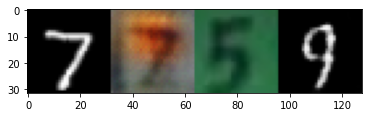

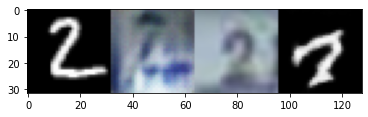

it[1100/4685] 	Loss_D:2.2051 	Loss_G:2.1591 	Loss_C:0.3471 	elapsed_time:1.02mins
it[1200/4685] 	Loss_D:1.9945 	Loss_G:2.2047 	Loss_C:0.2898 	elapsed_time:1.11mins
it[1300/4685] 	Loss_D:2.1705 	Loss_G:2.4302 	Loss_C:0.3664 	elapsed_time:1.20mins
it[1400/4685] 	Loss_D:2.0792 	Loss_G:2.1732 	Loss_C:0.3884 	elapsed_time:1.29mins
it[1500/4685] 	Loss_D:2.2446 	Loss_G:2.1232 	Loss_C:0.3307 	elapsed_time:1.38mins
it[1600/4685] 	Loss_D:2.1123 	Loss_G:2.0376 	Loss_C:0.3442 	elapsed_time:1.47mins
it[1700/4685] 	Loss_D:2.0178 	Loss_G:2.2483 	Loss_C:0.3379 	elapsed_time:1.56mins
it[1800/4685] 	Loss_D:2.0768 	Loss_G:2.0417 	Loss_C:0.3043 	elapsed_time:1.65mins
it[1900/4685] 	Loss_D:2.1262 	Loss_G:2.2933 	Loss_C:0.3591 	elapsed_time:1.75mins
it[2000/4685] 	Loss_D:2.2212 	Loss_G:1.9629 	Loss_C:0.3227 	elapsed_time:1.84mins


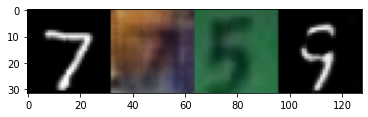

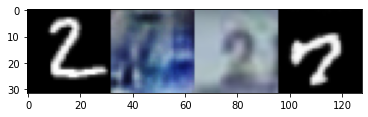

it[2100/4685] 	Loss_D:2.0407 	Loss_G:2.1682 	Loss_C:0.3266 	elapsed_time:1.95mins
it[2200/4685] 	Loss_D:1.9033 	Loss_G:2.3662 	Loss_C:0.3648 	elapsed_time:2.04mins
it[2300/4685] 	Loss_D:2.2072 	Loss_G:2.0036 	Loss_C:0.3501 	elapsed_time:2.13mins
it[2400/4685] 	Loss_D:2.1300 	Loss_G:2.2952 	Loss_C:0.3375 	elapsed_time:2.22mins
it[2500/4685] 	Loss_D:2.1447 	Loss_G:2.3477 	Loss_C:0.3206 	elapsed_time:2.31mins
it[2600/4685] 	Loss_D:2.1526 	Loss_G:2.2630 	Loss_C:0.3029 	elapsed_time:2.41mins
it[2700/4685] 	Loss_D:2.4853 	Loss_G:1.7865 	Loss_C:0.3505 	elapsed_time:2.50mins
it[2800/4685] 	Loss_D:2.2438 	Loss_G:2.1136 	Loss_C:0.3462 	elapsed_time:2.60mins
it[2900/4685] 	Loss_D:2.2119 	Loss_G:2.0573 	Loss_C:0.3405 	elapsed_time:2.69mins
it[3000/4685] 	Loss_D:2.2344 	Loss_G:2.1350 	Loss_C:0.3219 	elapsed_time:2.78mins


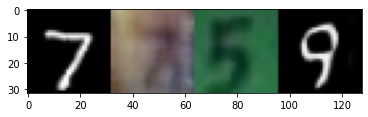

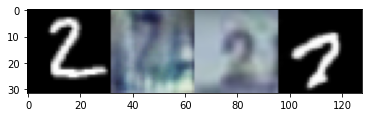

it[3100/4685] 	Loss_D:1.9632 	Loss_G:2.2702 	Loss_C:0.3702 	elapsed_time:2.89mins
it[3200/4685] 	Loss_D:2.2244 	Loss_G:2.4170 	Loss_C:0.3426 	elapsed_time:2.98mins
it[3300/4685] 	Loss_D:2.3266 	Loss_G:2.2265 	Loss_C:0.3071 	elapsed_time:3.08mins
it[3400/4685] 	Loss_D:2.1445 	Loss_G:2.1126 	Loss_C:0.3434 	elapsed_time:3.17mins
it[3500/4685] 	Loss_D:1.9974 	Loss_G:2.2559 	Loss_C:0.3235 	elapsed_time:3.27mins
it[3600/4685] 	Loss_D:2.0054 	Loss_G:2.4796 	Loss_C:0.2994 	elapsed_time:3.37mins
it[3700/4685] 	Loss_D:2.0213 	Loss_G:2.0695 	Loss_C:0.3220 	elapsed_time:3.46mins
it[3800/4685] 	Loss_D:2.3839 	Loss_G:2.0518 	Loss_C:0.3341 	elapsed_time:3.56mins
it[3900/4685] 	Loss_D:2.1639 	Loss_G:2.3502 	Loss_C:0.3282 	elapsed_time:3.66mins
it[4000/4685] 	Loss_D:2.5303 	Loss_G:1.6903 	Loss_C:0.3341 	elapsed_time:3.76mins


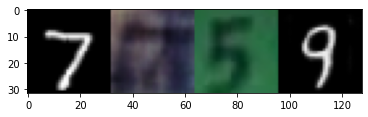

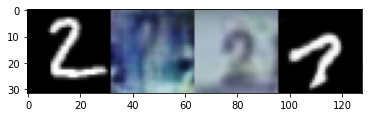

it[4100/4685] 	Loss_D:2.0954 	Loss_G:2.3514 	Loss_C:0.3355 	elapsed_time:3.88mins
it[4200/4685] 	Loss_D:2.2011 	Loss_G:2.2823 	Loss_C:0.3122 	elapsed_time:3.98mins
it[4300/4685] 	Loss_D:2.3241 	Loss_G:1.9974 	Loss_C:0.3283 	elapsed_time:4.08mins
it[4400/4685] 	Loss_D:2.1954 	Loss_G:2.1869 	Loss_C:0.3470 	elapsed_time:4.17mins
it[4500/4685] 	Loss_D:2.3141 	Loss_G:2.0155 	Loss_C:0.3111 	elapsed_time:4.27mins
it[4600/4685] 	Loss_D:2.1009 	Loss_G:2.1476 	Loss_C:0.3333 	elapsed_time:4.37mins


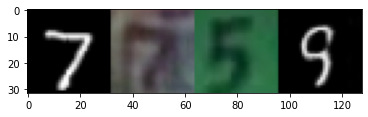

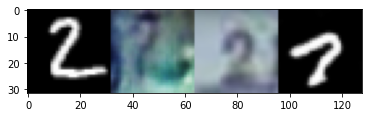

In [13]:
print('STEP 7: TRAIN THE MODEL')

label_real = torch.full((bs, 1, 8, 8), real_label, dtype=torch.float32, device=device)
label_fake = torch.full((bs, 1, 8, 8), fake_label, dtype=torch.float32, device=device)

num_iter = 0
max_iter = num_epochs*len(train_X_loader)

train_start_time = time.time()
for epoch in range(1, num_epochs+1):
    for batch_index, data_X in enumerate(train_X_loader):
        model_G_X.train() # 3->1 SVHN to MNIST
        model_G_Y.train() # 1->3 MNIST to SVHN
        model_D_X.train() # 1->1
        model_D_Y.train() # 3->1
        
        data_X = data_X[0].to(device)
        data_Y = next(iter(train_Y_loader))[0].to(device)
        
        ### Update discriminator model
        model_D_X.zero_grad()
        model_D_Y.zero_grad()
        
        # Train D_Y
        D_Y_real_loss = criterion_GAN(model_D_Y(data_Y), label_real)
        D_Y_fake_loss = criterion_GAN(model_D_Y(model_G_Y(data_X)), label_fake)
        
        # Train D_X
        D_X_real_loss = criterion_GAN(model_D_X(data_X), label_real)
        D_X_fake_loss = criterion_GAN(model_D_X(model_G_X(data_Y)), label_fake)
        
        err_D = D_Y_real_loss + D_Y_fake_loss + D_X_real_loss + D_X_fake_loss
        err_D.backward()
        optimizer_D_X.step()
        optimizer_D_Y.step()
        
        ### Update generator model
        # Generative model Loss
        model_G_X.zero_grad()
        model_G_Y.zero_grad()
        
        G_X_real_loss = criterion_GAN(model_D_X(model_G_X(data_Y)), label_real)
        G_Y_real_loss = criterion_GAN(model_D_Y(model_G_Y(data_X)), label_real)
        
        err_G = G_X_real_loss + G_Y_real_loss
        err_G.backward()
        optimizer_G_X.step()
        optimizer_G_Y.step()
        
        # Cycle Loss
        model_G_X.zero_grad()
        model_G_Y.zero_grad()
        C_X_loss = criterion_L1(model_G_Y(model_G_X(data_Y)), data_Y)
        C_Y_loss = criterion_L1(model_G_X(model_G_Y(data_X)), data_X)
        
        err_C = C_X_loss + C_Y_loss
        err_C.backward()
        
        optimizer_G_X.step()
        optimizer_G_Y.step()
        
        num_iter += 1
        # Output training stats
        if num_iter%100 == 0:
            print('it[{:04d}/{:04d}] \tLoss_D:{:.4f} \tLoss_G:{:.4f} \tLoss_C:{:.4f} \telapsed_time:{:.2f}mins'.format(
                num_iter, max_iter, err_D.item(), err_G.item(), err_C.item(), (time.time()-train_start_time)/60 
            ))

        if num_iter%1000==0 or num_iter==max_iter:
            save_name = osp.join(save_dir, 'it{:04d}.pt'.format(num_iter))
            torch.save({
                'model_G_X': model_G_X.state_dict(),
                'model_G_Y': model_G_Y.state_dict()
            }, save_name)
    
            with torch.no_grad():
                model_G_X.eval()
                model_G_Y.eval()
                for test_index, data_X in enumerate(test_X_loader):
                    if test_index == 0: 
                        data_X = data_X[0].to(device)
                        data_Y = next(iter(test_Y_loader))[0].to(device)

                        #output_X = model_G_X(data_X)
                        #output_Y = model_G_Y(data_Y)
                        output_X = model_G_X(data_Y)
                        output_Y = model_G_Y(data_X)
                        
                        data_X = ((data_X+1)/2).cpu().data.numpy()
                        data_Y = ((data_Y+1)/2).cpu().data.numpy()

                        output_X = ((output_X + 1)/2).cpu().data.numpy()
                        output_Y = ((output_Y + 1)/2).cpu().data.numpy()
                
                        for vis_idx in range(vis_num):
                            data_X_, data_Y_ = gray2rgb(transpose(data_X)[vis_idx]), transpose(data_Y)[vis_idx]
                            #output_X_, output_Y_  = transpose(output_X)[vis_idx], gray2rgb(transpose(output_Y)[vis_idx])
                            output_Y_, output_X_  = gray2rgb(transpose(output_X)[vis_idx]), transpose(output_Y)[vis_idx]
                            outputs = np.concatenate((data_X_, output_X_, data_Y_, output_Y_), axis=1)
                            plt.imshow(outputs)
                            plt.pause(0.001)

Analysis
=
> Cha, Hyunsoo

I tried to move the loss function to implement the training code. G_X received data_Y as input, converted it to X, and trained the discriminator model in the form of determining it, and implemented error backwards. The generator model converts data_X to Y via G_Y, which is designed to be determined by each discriminator. CycleLoss has implemented data_Y to be passed to G_X, replaced by X, and passed to G_Y to convert it back to Y, so that it can be compared to the original data_Y. To properly represent the results, I make some modifications to the second half code. Model G_X can only contain data_Y. Analyzing the final results, the first column of photographs corresponds to the original MNIST data_X, and the second is MNIST converted to SVHN. The third is the original SVHN photo, and the last column is the conversion of SVHN to MNIST. As a result, it can be seen that it has been successful.